# Plot leadtime seasonal comparisons

For CNN2 network, read in results from seasonal prediction tests

In [23]:
import matplotlib.pyplot as plt
import numpy as np

In [24]:
# Paths
datpath = "/Users/gliu/Downloads/2020_Fall/6.862/Project/CESM_data/Metrics/" # path to the data
outpath = "/Users/gliu/Downloads/2020_Fall/6.862/Project/Figures/" # output directory

# Experiment parameters
leadtime   = 25  # Lead time in months (include lag 0)
num_epochs = 10   # Number of Epochs tested for
nmembers   = 40   # Total number of ensemble members used 
netname    = 'CNN2' # Network Type [CNN1,CNN2,FNN,LR]
netlong    = "2-Layer CNN (CNN2)" # Network Long Name
#season     = 'Ann'
resolution = '2deg'
indexregion = 'NAT'

# Save Figures? (Set to True to save to outpath)
savefigures = True

# Set variable names
varnames = ["SST","SSS","PSL","ALL"]
seasons  = ["Ann","DJF","MAM","JJA","SON"]

In [25]:
def calc_AMV_index(region,invar,lat,lon):
    """
    Select bounding box for a given AMV region for an input variable
        "SPG" - Subpolar Gyre
        "STG" - Subtropical Gyre
        "TRO" - Tropics
        "NAT" - North Atlantic
    
    Parameters
    ----------
    region : STR
        One of following the 3-letter combinations indicating selected region
        ("SPG","STG","TRO","NAT")
        
    var : ARRAY [Ensemble x time x lat x lon]
        Input Array to select from
    lat : ARRAY
        Latitude values
    lon : ARRAY
        Longitude values    

    Returns
    -------
    amv_index [ensemble x time]
        AMV Index for a given region/variable

    """
    
    # Select AMV Index region
    bbox_SP = [-60,-15,40,65]
    bbox_ST = [-80,-10,20,40]
    bbox_TR = [-75,-15,0,20]
    bbox_NA = [-80,0 ,0,65]
    regions = ("SPG","STG","TRO","NAT")        # Region Names
    bboxes = (bbox_SP,bbox_ST,bbox_TR,bbox_NA) # Bounding Boxes
    
    # Get bounding box
    bbox = bboxes[regions.index(region)]
    
    # Select Region
    selvar = invar.copy()
    klon = np.where((lon>=bbox[0]) & (lon<=bbox[1]))[0]
    klat = np.where((lat>=bbox[2]) & (lat<=bbox[3]))[0]
    selvar = selvar[:,:,klat[:,None],klon[None,:]]
    
    # Take mean ove region
    amv_index = np.nanmean(selvar,(2,3))
    
    return amv_index

In [26]:
%%time
# Begin by calculating AMV Index for each season
amvindices = []

# Calculate Autocorrelation
tstep = 86
lags  = 25

# Load in annual data

lon = np.load("../../CESM_data/lon_%s_NAT.npy"%(resolution))
lat = np.load("../../CESM_data/lat_%s_NAT.npy"%(resolution))

for season in seasons:
    # Load in data
    sst_normed = np.load('../../CESM_data/CESM_sst_normalized_lat_weighted_%s_NAT_%s.npy' % (resolution,season)).astype(np.float32)
    
    sst_ensemble = calc_AMV_index(indexregion,sst_normed[:,:,:,:],lat,lon)

    sst_lagged_corr = np.zeros((nmembers,lags))
    #sss_lagged_corr = np.zeros((42,lags))

    for lead in range(lags):
        sst_lead = sst_ensemble[:,lead:]
        sst_lag = sst_ensemble[:,0:tstep-lead]
        #sss_lag = sss_ensemble[:,0:tstep-lead]

        for ien in range(nmembers):
            sst_lagged_corr[ien,lead] = np.corrcoef( sst_lead[ien,:],sst_lag[ien,:] )[0,1]    
    amvindices.append(sst_lagged_corr.copy())
    print("Calculated autocorrelation for %s"%season)

Calculated autocorrelation for Ann
Calculated autocorrelation for DJF
Calculated autocorrelation for MAM
Calculated autocorrelation for JJA
Calculated autocorrelation for SON
CPU times: user 588 ms, sys: 32.3 ms, total: 620 ms
Wall time: 619 ms


<bound method Artist.set of <AxesSubplot:title={'center':'CESM1 Ensemble Average Seasonal Persistence'}>>

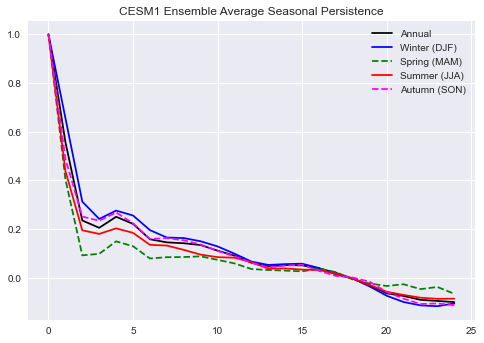

In [27]:
# Compare persistence between regions

slongname = ["Annual","Winter (DJF)","Spring (MAM)","Summer (JJA)","Autumn (SON)"]
slines   = ["solid","solid","dashed","solid","dashed"]
scolors  = ["black","blue","green","red","magenta"]
plotlags = np.arange(0,25,1)
fig,ax = plt.subplots(1,1)
plt.style.use('seaborn')
plt.style.use('seaborn-bright')

for s,season in enumerate(seasons):
    ax.plot(plotlags,amvindices[s].mean(0),label=slongname[s],ls=slines[s],color=scolors[s])
ax.legend()
ax.set_title("CESM1 Ensemble Average Seasonal Persistence")
ax.set

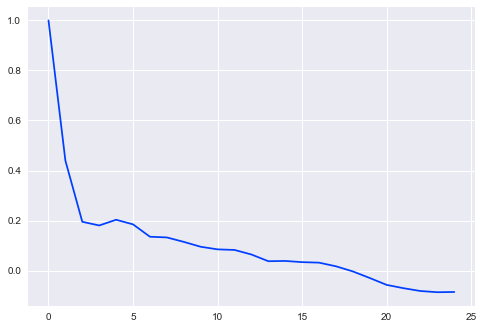

In [14]:
s=3
plt.plot(amvindices[s].mean(0))